In [1]:
import sys
sys.path.insert(0, '../src/')

from netgan.netgan import *
import tensorflow as tf
import torch
from netgan import utils
import scipy.sparse as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import time
import net.net as net
%matplotlib inline

/home/holgerizor/anaconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/holgerizor/anaconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/holgerizor/anaconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/holgerizor/anaconda3/envs/ne

In [2]:
import numpy as np
from scipy.sparse.linalg import eigs

def scores_matrix_from_transition_matrix(transition_matrix, mixing_coeff=1, samples=[], symmetric=True):
    """
    Compute the transition scores, i.e. the probability of a transition, for all node pairs from
    the transition matrix provided.
    Parameters
    ----------
    transition_matrix: np.array of shape (N, N)
                  The input transition matrix to count the transitions in.
    samples: integer
               If provided, scales the output to a score matrix that is comparable with the one obtained
               obtained from sampling random walks.
    mixing_coeff: float in [0,1]
               Controls contributions of stationary distribution and uniform distribution. 0 is uniform,
               1 is stationary.
    symmetric: bool, default: True
               Whether to symmetrize the resulting scores matrix.

    Returns
    -------
    scores_matrix: sparse matrix, shape (N, N)
                   Matrix whose entries (i,j) correspond to the probability of a transition from node i to j 
                   for sampling random walks from the transition matrix provided. If samples is given, corresponds
                   to the expected number of transitions.

    """
    N = transition_matrix.shape[0]
    p_stationary = np.real(eigs(transition_matrix.T, k=1, sigma=1)[1])
    p_stationary /= p_stationary.sum()
    p_marginal = mixing_coeff * p_stationary + ((1 - mixing_coeff) / N) * np.ones_like(p_stationary)
    scores_matrix = p_marginal * transition_matrix
    
    if symmetric:
        scores_matrix += scores_matrix.T
    
    if samples: 
        scores_matrix *= samples
    
    return scores_matrix

#### Load the data

In [3]:
_A_obs, _X_obs, _z_obs = utils.load_npz('../data/cora_ml.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

Selecting 1 largest connected components


In [4]:
val_share = 0.1
test_share = 0.05
seed = 481516234

#### Separate the edges into train, test, validation

In [5]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=True)

In [6]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

#### Parameters

In [7]:
rw_len = 16
batch_size = 128

In [8]:
def net_walker(walker):
    rw_generator = walker.walk()
    while True:
        random_walks = next(rw_generator)
        yield transform_to_transitions(random_walks)

def transform_to_transitions(random_walks):
    x = torch.tensor(random_walks[:, :-1].reshape([-1]))
    y = torch.tensor(random_walks[:, 1:].reshape([-1]))
    return x, y

In [9]:
walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)

#### Create our Net model

In [89]:
netmodel = net.Net(N=_N,
                   H=128,
                   loss_fn=torch.nn.functional.cross_entropy,
                   loggers=[net.BasicPrintLogger(print_every=100)])

#### Train our model

In [90]:
netmodel.train(generator=net_walker(walker),
               steps=100,
               optimizer_fn=torch.optim.Adam,
               optimizer_args={'lr': 0.01})

Step: 99, Loss: 2.32953


#### Evaluate our model

In [91]:
transition_matrix = netmodel(torch.arange(start=0,end=_N, dtype=int))

In [92]:
scores_matrix = scores_matrix_from_transition_matrix(transition_matrix=transition_matrix, symmetric=True)

In [93]:
scores_matrix = sp.csr_matrix(scores_matrix)

#### Evaluate generalization via link prediction

In [94]:
test_labels = np.concatenate((np.ones(len(test_ones)), np.zeros(len(test_zeros))))
test_scores = np.concatenate((scores_matrix[tuple(test_ones.T)].A1, scores_matrix[tuple(test_zeros.T)].A1))

In [95]:
roc_auc_score(test_labels, test_scores)

0.9183125000000001

In [96]:
average_precision_score(test_labels, test_scores)

0.9354214294887749

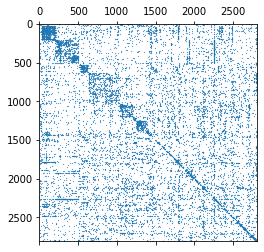

In [97]:
sampled_graph = utils.graph_from_scores(scores_matrix, train_graph.sum())
plt.spy(sampled_graph, markersize=.2)
plt.show()

In [98]:
sampled_graph.sum()

13566.0

In [99]:
utils.edge_overlap(train_graph.toarray(), sampled_graph)/train_graph.sum()

0.7574819401444789

In [100]:
utils.compute_graph_statistics(sampled_graph)

/home/holgerizor/anaconda3/envs/netgan/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


{'d_max': 210.0,
 'd_min': 1.0,
 'd': 4.8277580071174375,
 'LCC': 2792,
 'wedge_count': 89677.0,
 'claw_count': 2137417.0,
 'triangle_count': 1663,
 'square_count': 161,
 'power_law_exp': 1.8430376766255308,
 'gini': 0.47084185238058507,
 'rel_edge_distr_entropy': 0.9449222915707338,
 'assortativity': -0.07375114128657255,
 'clustering_coefficient': 0.0023341257227766036,
 'n_components': 7,
 'cpl': 4.970922598515087}